In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import linregress, uniform
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
df = pd.read_csv('Lead Scoring.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
df.shape

(9240, 37)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [7]:
binary_cats = ['Do Not Email','Do Not Call','Search','Magazine','Newspaper Article',
               'X Education Forums','Newspaper','Digital Advertisement','Through Recommendations',
               'Receive More Updates About Our Courses', 'Update me on Supply Chain Content','Get updates on DM Content',
               'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']

null_values = df[binary_cats].isnull().sum()
total = df[binary_cats].count()
yes_no = df[binary_cats].applymap(lambda x: 1 if x == 'Yes' or x == 'No' else 0).sum()
df_binary_cats = pd.DataFrame({'total': total,
                               'null_%': null_values/total*100,
                               'yes/no_%': yes_no/total*100})
df_binary_cats

,total,null_%,yes/no_%
Do Not Email,9240,0.0,100.0
Do Not Call,9240,0.0,100.0
Search,9240,0.0,100.0
Magazine,9240,0.0,100.0
Newspaper Article,9240,0.0,100.0
X Education Forums,9240,0.0,100.0
Newspaper,9240,0.0,100.0
Digital Advertisement,9240,0.0,100.0
Through Recommendations,9240,0.0,100.0
Receive More Updates About Our Courses,9240,0.0,100.0


In [8]:
train, test = train_test_split(df, test_size=.2, random_state=12, stratify=df['Converted'])
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (7392, 37)
test shape: (1848, 37)


In [9]:
print(f'In the train set are {train.duplicated().sum()} duplicates')

In the train set are 0 duplicates


In [10]:
train['Asymmetrique Profile Index'].value_counts(dropna=False)


Asymmetrique Profile Index
NaN          3362
02.Medium    2243
01.High      1762
03.Low         25
Name: count, dtype: int64

In [11]:
train['Asymmetrique Activity Index'].value_counts(dropna=False)


Asymmetrique Activity Index
NaN          3362
02.Medium    3080
01.High       648
03.Low        302
Name: count, dtype: int64

In [12]:
def data_cleaning(df):
  """Do some of the data cleaning procedures that we
  specified at the begining of the notebook"""
  # drop columns id columns
  df = df.drop(['Prospect ID','Lead Number'], axis=1)

  # asymmetrique index columns transformation
  df['Asymmetrique Activity Index'] = df['Asymmetrique Activity Index'].str.split('.', expand=True)[0]\
                                                                        .str.replace('0','').str.replace('1','4')\
                                                                        .str.replace('3','1').str.replace('4','3')\
                                                                        .astype(np.float64
                                                                               )
  df['Asymmetrique Profile Index'] = df['Asymmetrique Profile Index'].str.split('.', expand=True)[0]\
                                                                        .str.replace('0','').str.replace('1','4')\
                                                                        .str.replace('3','1').str.replace('4','3')\
                                                                        .astype(np.float64
                                                                               )
  # binary encoding
  df[binary_cats] = df[binary_cats].applymap(lambda x: 0 if x == 'No' else 1)
    
  # rename columns for practicity
  df.columns = df.columns.str.replace(' ','_').str.lower()
  return df

# Convert custom function into transformer
initial_clean = FunctionTransformer(data_cleaning)

train_clean = initial_clean.fit_transform(train);

In [13]:
train_clean.lead_origin.value_counts(dropna=False)

lead_origin
Landing Page Submission    3906
API                        2889
Lead Add Form               550
Lead Import                  47
Name: count, dtype: int64

In [14]:
train_clean.lead_source.value_counts(dropna=False)


lead_source
Google               2326
Direct Traffic       2033
Olark Chat           1408
Organic Search        916
Reference             405
Welingak Website      111
Referral Sites         98
Facebook               46
NaN                    27
bing                    6
Click2call              4
google                  3
Live Chat               2
blog                    1
testone                 1
Social Media            1
youtubechannel          1
WeLearn                 1
Press_Release           1
Pay per Click Ads       1
Name: count, dtype: int64

In [15]:
train_clean.last_activity.value_counts(dropna=False)


last_activity
Email Opened                    2712
SMS Sent                        2224
Olark Chat Conversation          793
Page Visited on Website          506
Converted to Lead                336
Email Bounced                    271
Email Link Clicked               211
Form Submitted on Website         97
NaN                               80
Unreachable                       71
Unsubscribed                      50
Had a Phone Conversation          23
Approached upfront                 8
View in browser link Clicked       5
Email Received                     2
Resubscribed to emails             1
Email Marked Spam                  1
Visited Booth in Tradeshow         1
Name: count, dtype: int64

In [16]:
train_clean.country.value_counts(dropna=False)


country
India                   5201
NaN                     1954
United States             57
United Arab Emirates      49
Singapore                 21
Saudi Arabia              17
United Kingdom            13
Australia                  9
Qatar                      9
Bahrain                    6
Oman                       4
Nigeria                    4
Germany                    4
France                     4
unknown                    4
Kuwait                     3
Hong Kong                  3
Canada                     3
South Africa               3
China                      2
Belgium                    2
Sweden                     2
Italy                      2
Bangladesh                 2
Ghana                      2
Netherlands                2
Switzerland                1
Denmark                    1
Uganda                     1
Tanzania                   1
Russia                     1
Philippines                1
Malaysia                   1
Sri Lanka                  1
Asia/P

In [17]:
train_clean.specialization.value_counts(dropna=False)

specialization
Select                               1554
NaN                                  1154
Finance Management                    780
Marketing Management                  682
Human Resource Management             661
Operations Management                 407
Business Administration               329
IT Projects Management                295
Supply Chain Management               281
Banking, Investment And Insurance     272
Media and Advertising                 161
Travel and Tourism                    155
International Business                152
Healthcare Management                 128
Hospitality Management                 89
E-COMMERCE                             84
Retail Management                      76
Rural and Agribusiness                 59
E-Business                             43
Services Excellence                    30
Name: count, dtype: int64

In [18]:
train_clean.how_did_you_hear_about_x_education.value_counts(dropna=False)

how_did_you_hear_about_x_education
Select                   4023
NaN                      1768
Online Search             647
Word Of Mouth             288
Student of SomeSchool     258
Other                     139
Multiple Sources          128
Social Media               51
Advertisements             49
SMS                        21
Email                      20
Name: count, dtype: int64

In [19]:
train_clean.what_is_your_current_occupation.value_counts(dropna=False)

what_is_your_current_occupation
Unemployed              4474
NaN                     2159
Working Professional     559
Student                  172
Other                     14
Housewife                  8
Businessman                6
Name: count, dtype: int64

In [20]:
train_clean.what_matters_most_to_you_in_choosing_a_course.value_counts(dropna=False)

what_matters_most_to_you_in_choosing_a_course
Better Career Prospects      5216
NaN                          2173
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [21]:
train_clean.tags.value_counts(dropna=False)

tags
NaN                                                  2687
Will revert after reading the email                  1664
Ringing                                               958
Interested in other courses                           418
Already a student                                     365
Closed by Horizzon                                    287
switched off                                          200
Busy                                                  146
Lost to EINS                                          138
Not doing further education                           110
Interested  in full time MBA                           92
Graduation in progress                                 87
invalid number                                         60
Diploma holder (Not Eligible)                          51
wrong number given                                     42
opp hangup                                             29
number not provided                                    21
in touch 

In [22]:
train_clean.lead_quality.value_counts(dropna=False)

lead_quality
NaN                  3796
Might be             1249
Not Sure              884
High in Relevance     508
Worst                 490
Low in Relevance      465
Name: count, dtype: int64

In [23]:
train_clean.lead_profile.value_counts(dropna=False)

lead_profile
Select                         3283
NaN                            2173
Potential Lead                 1316
Other Leads                     393
Student of SomeSchool           187
Lateral Student                  22
Dual Specialization Student      18
Name: count, dtype: int64

In [24]:
train_clean.city.value_counts(dropna=False)

city
Mumbai                         2581
Select                         1806
NaN                            1139
Thane & Outskirts               607
Other Cities                    539
Other Cities of Maharashtra     349
Other Metro Cities              307
Tier II Cities                   64
Name: count, dtype: int64

In [25]:
train_clean.last_notable_activity.value_counts(dropna=False)

last_notable_activity
Modified                        2734
Email Opened                    2219
SMS Sent                        1759
Page Visited on Website          259
Olark Chat Conversation          153
Email Link Clicked               140
Email Bounced                     49
Unsubscribed                      39
Unreachable                       24
Had a Phone Conversation          10
Form Submitted on Website          1
Email Received                     1
View in browser link Clicked       1
Resubscribed to emails             1
Email Marked Spam                  1
Approached upfront                 1
Name: count, dtype: int64

In [26]:
def initial_feature_engineering(df):
  """Do some feature engineering"""
  # lead_source
  df['lead_source'] = df['lead_source'].str.replace('|'.join(['google','Pay per Click Ads']),'Google')
  df['lead_source'] = df['lead_source'].apply(lambda x: "Referral Sites" if 'blog' in str(x) else x)
  df['lead_source'] = df['lead_source'].str.replace('Live Chat','Olark Chat')
  df['lead_source'] = df['lead_source'].str.replace('bing','Organic Search')
  df['lead_source'] = df[df['lead_source'] != 'Other'].lead_source.apply(lambda x: "Other" if str(x) not in train_clean.lead_source.value_counts()[:8].index else x)
  # last_activity and last_notable_activity
  activity = ['last_activity','last_notable_activity']
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Email Received','SMS Sent']),'SMS/Email Sent'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Email Marked Spam','Email Bounced','Unsubscribed']),'Not interested in email'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('Resubscribed to emails','Email Opened'))
  df[activity] = df[activity].apply(lambda x: x.str.replace('|'.join(['Visited Booth in Tradeshow','View in browser link Clicked']),'Page Visited on Website'))
  # country
  df['country'] = df['country'].apply(lambda x: np.nan if x in ['Unknown','unknown','Asia/Pacific Region'] else x)
  # specialization
  df['specialization'] = df['specialization'].str.replace('|'.join(['E-COMMERCE','E-Business']),'E-commerce')
  df['specialization'] = df['specialization'].str.replace('Banking, Investment And Insurance','Finance Management')
  df['specialization'] = df['specialization'].str.replace('Media and Advertising','Marketing Management')
  df['specialization'] = df['specialization'].str.replace('Select','Not Provided')
  # how_did_you_hear
  df['how_did_you_hear_about_x_education'] = df['how_did_you_hear_about_x_education'].str.replace('Select','Not Provided')
  df['how_did_you_hear_about_x_education'] = df['how_did_you_hear_about_x_education'].str.replace('|'.join(['SMS','Email']),'SMS/Email')
  # importance_in_course
  df['what_matters_most_to_you_in_choosing_a_course'] = df['what_matters_most_to_you_in_choosing_a_course'].str.replace('|'.join(['Flexibility & Convenience','Other']),"Better Career Prospects")
  # lead_profile
  df['lead_profile'] = df['lead_profile'].str.replace('Select','Not Assigned')
  # city
  df['city'] = df['city'].str.replace('Select','Not Provided')

  return df

initial_feature_engineering = FunctionTransformer(initial_feature_engineering)
train_clean = initial_feature_engineering.fit_transform(train_clean)

In [27]:
train_ = train_clean.copy()

# Set style for better visualizations
train_eda = train.copy()
sns.set_style('dark')
sns.set(rc={'axes.grid':False})
sns.set_palette('viridis')


In [28]:
null_ = pd.DataFrame()
null_['proportion'] = np.round(train_clean.isnull().sum()/len(train_clean),4) * 100
null_['amount'] = train_clean.isnull().sum()

# Show only those columns with at least 1 missing value
null_.sort_values(by='proportion', ascending=False)[null_.amount > 0]

,proportion,amount
lead_quality,51.35,3796
asymmetrique_activity_index,45.48,3362
asymmetrique_profile_score,45.48,3362
asymmetrique_profile_index,45.48,3362
asymmetrique_activity_score,45.48,3362
tags,36.35,2687
lead_profile,29.40,2173
what_matters_most_to_you_in_choosing_a_course,29.40,2173
what_is_your_current_occupation,29.21,2159
country,26.50,1959


In [29]:
def barplot_catcols(column,width,heigh):
  """Plot conversion rate"""
  fig, ax  = plt.subplots(figsize=(width,heigh))
  ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y=column,
            order=order(train_.fillna('NaN'),column),
            orient='h', palette='viridis',
            seed=2)
  plt.title(f'Conversion Rate by {column.replace("_"," ").title()}', loc='left', size=18)
  return ax

def order(df,x,y=None):
    if y is not None:
        return df.groupby(x)[y].mean().sort_values(ascending=False).index
    else:
        return df.groupby(x)['converted'].mean().sort_values(ascending=False).index


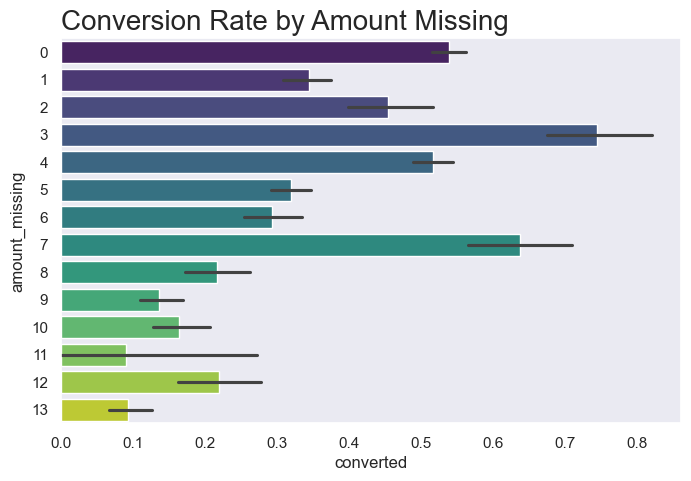

In [30]:
# Number of missing values in each row
train_['amount_missing'] = train_.isnull().sum(1)

# Plot the relation between amount missing and conversion rate
fig, ax  = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=train_.fillna('NaN'), x='converted', y='amount_missing',
            orient='h', palette='viridis',
            seed=2)
plt.title(f'Conversion Rate by Amount Missing', loc='left', size=20)
plt.show()


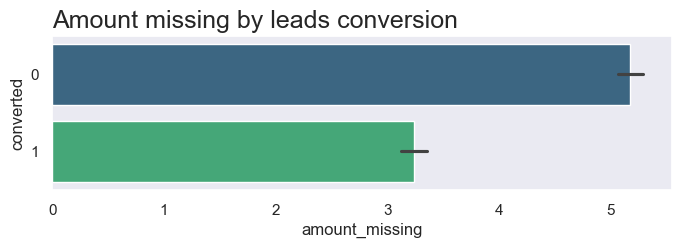

In [31]:
fig, ax  = plt.subplots(figsize=(8,2))
ax = sns.barplot(data=train_, x='amount_missing', y='converted',
            orient='h', palette=sns.color_palette('viridis',2),
            seed=2)
plt.title(f'Amount missing by leads conversion', loc='left', size=18)
plt.show()

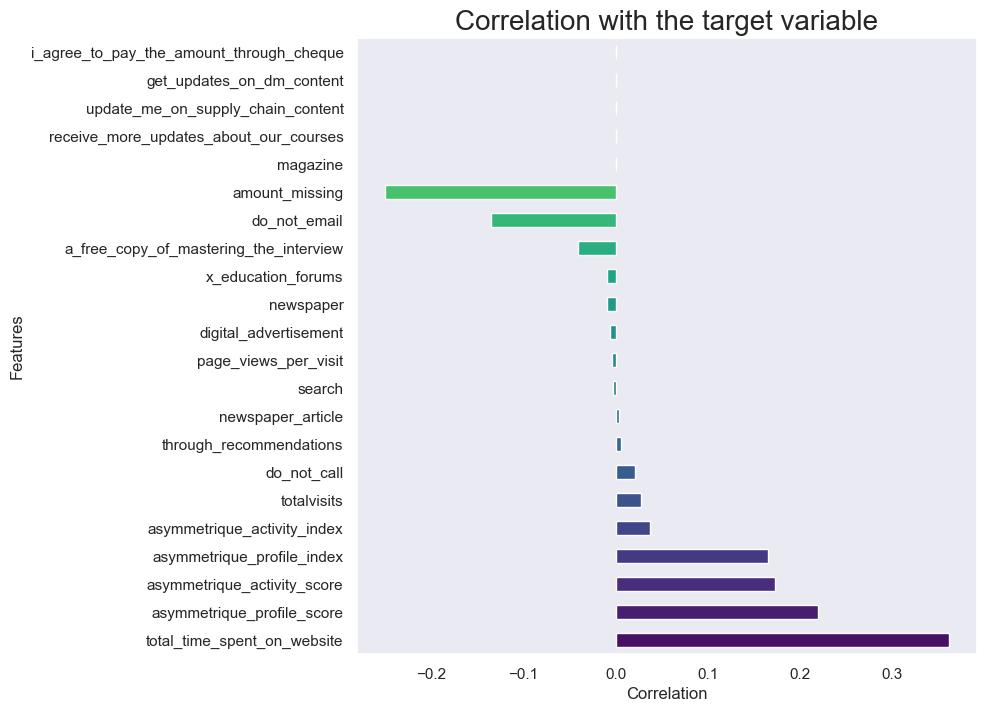

In [32]:
correlations = train_.select_dtypes('number').corr()['converted'].sort_values(ascending=False)

plt.figure(figsize=(8, 8))
correlations[1:].plot(kind='barh', 
                 color=sns.color_palette('viridis', len(correlations)))

plt.title('Correlation with the target variable', fontsize=20)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

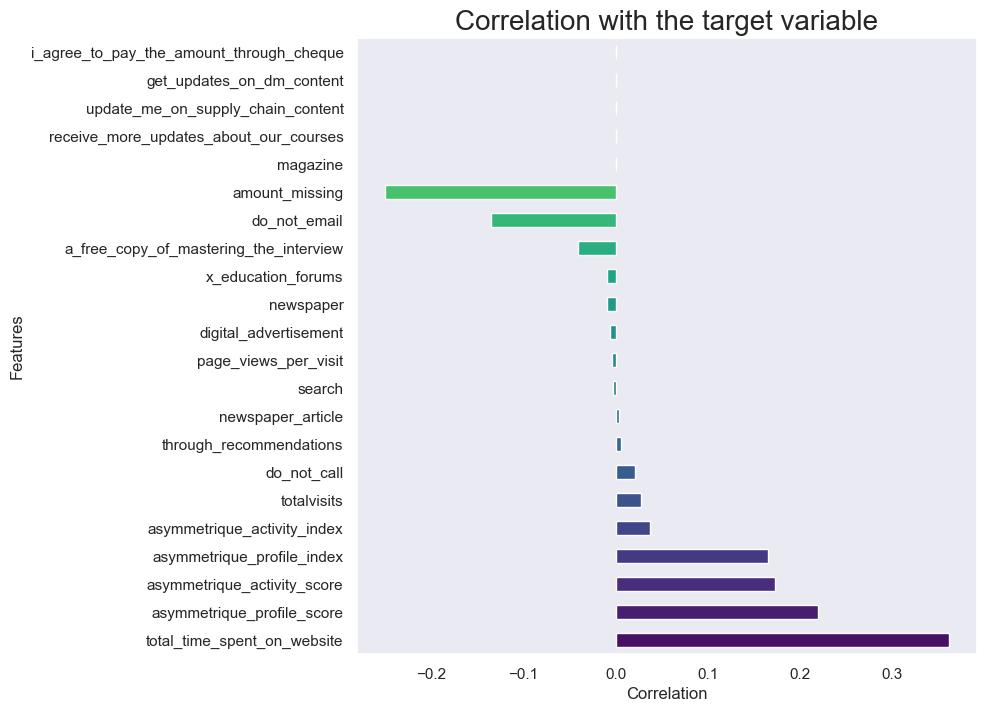

In [33]:
correlations = train_.select_dtypes('number').corr()['converted'].sort_values(ascending=False)

plt.figure(figsize=(8, 8))
correlations[1:].plot(kind='barh', 
                 color=sns.color_palette('viridis', len(correlations)))

plt.title('Correlation with the target variable', fontsize=20)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [34]:
print(f'Duplicate rows from original dataset: {train.duplicated().sum()}')
print(f'Duplicate rows after feature engineer: {train_clean.duplicated().sum()}')

Duplicate rows from original dataset: 0
Duplicate rows after feature engineer: 984


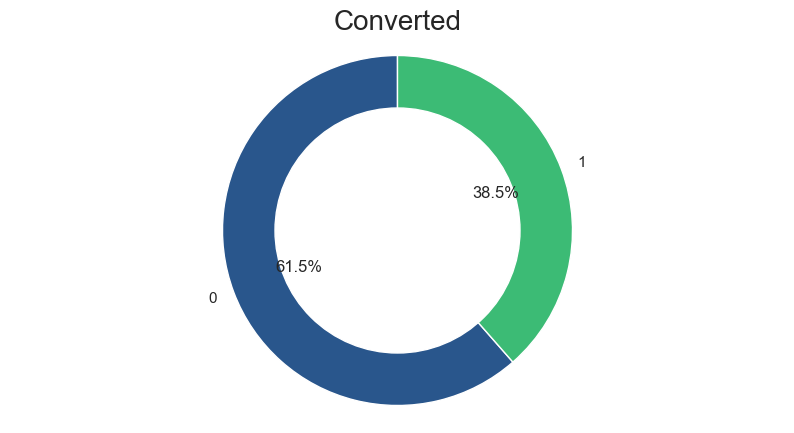

In [35]:
count = train_['converted'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
ax.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90, colors=['#29568CFF', '#3CBB75FF'])
ax.set_title('Converted', size=20)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()


In [36]:
train_.loc[:,'asymmetrique_activity_index':'asymmetrique_profile_score'].corr().style.background_gradient(cmap='vlag_r')

,asymmetrique_activity_index,asymmetrique_profile_index,asymmetrique_activity_score,asymmetrique_profile_score
asymmetrique_activity_index,1.000000,-0.145399,0.855985,-0.122669
asymmetrique_profile_index,-0.145399,1.000000,-0.145366,0.883177
asymmetrique_activity_score,0.855985,-0.145366,1.000000,-0.114636
asymmetrique_profile_score,-0.122669,0.883177,-0.114636,1.000000


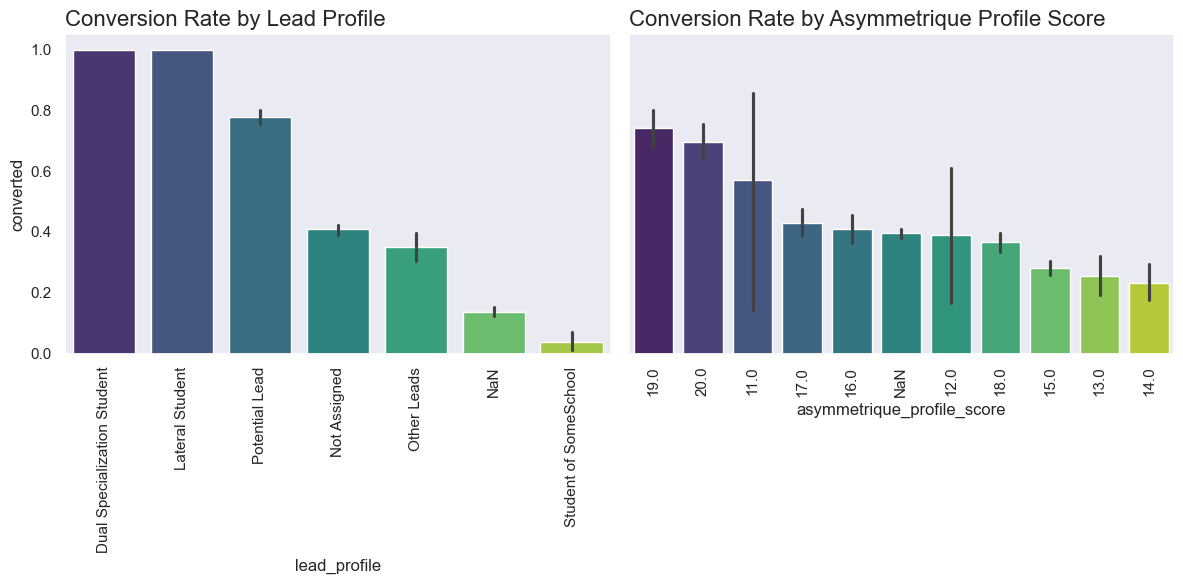

In [37]:
fig, ax  = plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='lead_profile', y='converted',
            palette='viridis', order=order(train_.fillna('NaN'),'lead_profile'),
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Lead Profile', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='asymmetrique_profile_score', y='converted',
                  palette='viridis', order=order(train_.fillna('NaN'),'asymmetrique_profile_score'),
                    seed=2, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Asymmetrique Profile Score', loc='left', size=16)

plt.tight_layout()
plt.show()

In [38]:
activity_columns = ['totalvisits','total_time_spent_on_website','page_views_per_visit',
                    'asymmetrique_profile_score','asymmetrique_activity_score']

train_[activity_columns].corr().style.background_gradient(cmap='vlag_r')

,totalvisits,total_time_spent_on_website,page_views_per_visit,asymmetrique_profile_score,asymmetrique_activity_score
totalvisits,1.000000,0.261952,0.598883,0.129016,-0.061397
total_time_spent_on_website,0.261952,1.000000,0.323684,0.167992,-0.066008
page_views_per_visit,0.598883,0.323684,1.000000,0.165945,-0.171264
asymmetrique_profile_score,0.129016,0.167992,0.165945,1.000000,-0.114636
asymmetrique_activity_score,-0.061397,-0.066008,-0.171264,-0.114636,1.000000


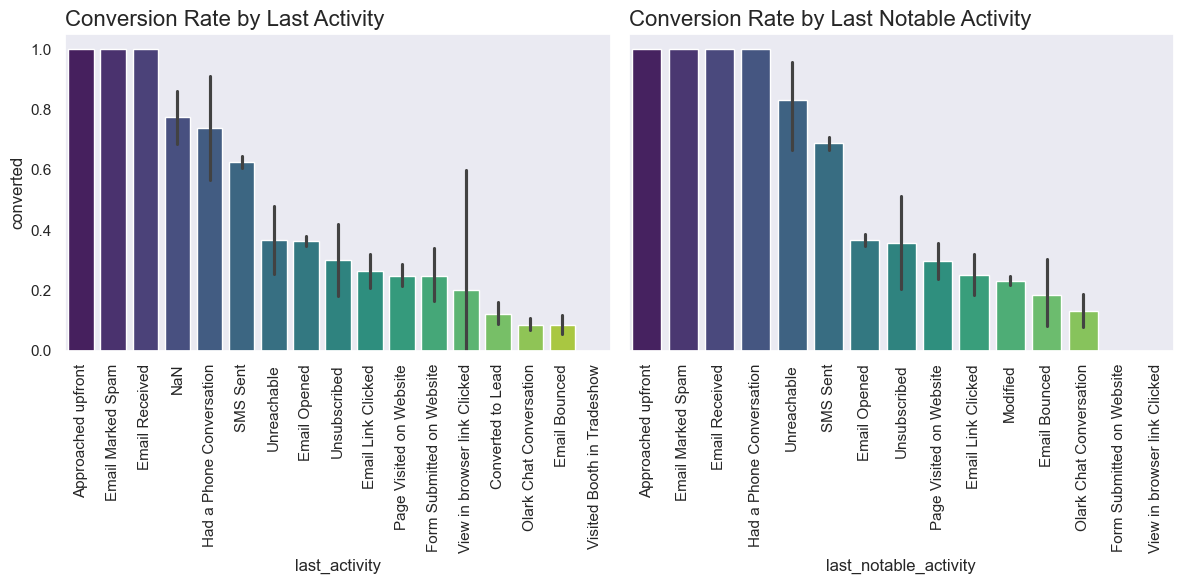

In [39]:
fig, ax  = plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='last_activity', y='converted',
            order=order(train_.fillna('NaN'),'last_activity'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Last Activity', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='last_notable_activity', y='converted',
                  order=order(train_.fillna('NaN'),'last_notable_activity'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Last Notable Activity', loc='left', size=16)

plt.tight_layout()
plt.show()

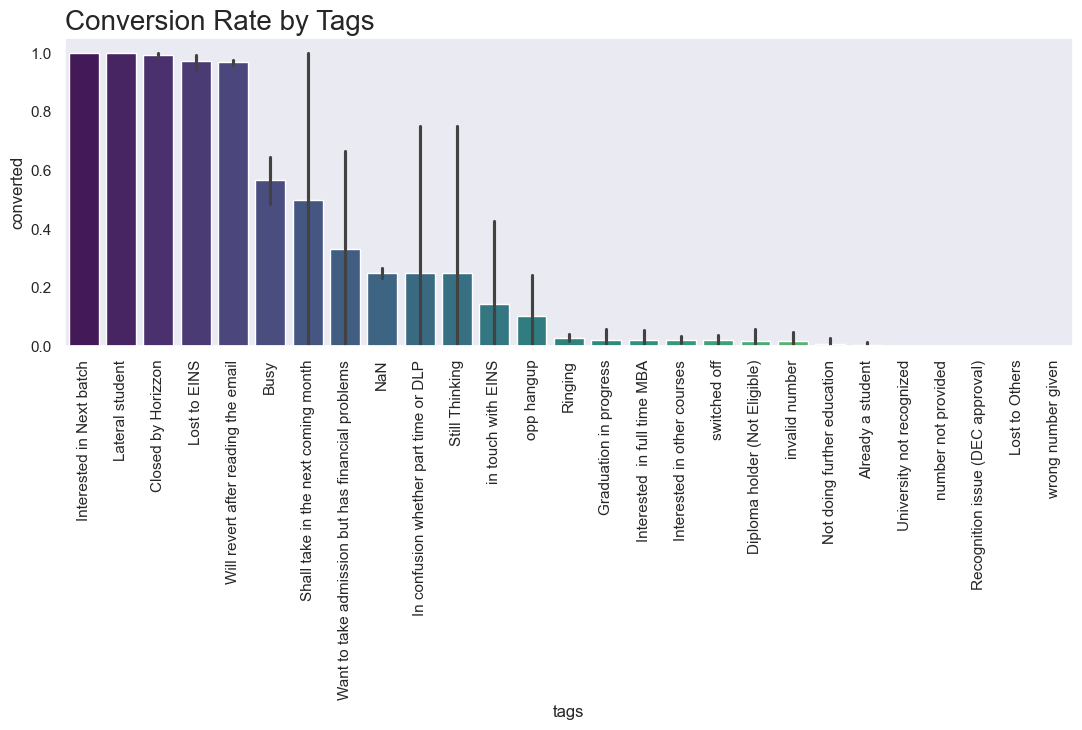

In [40]:
fig, ax  = plt.subplots(figsize=(13,4))

sns.barplot(data=train_.fillna('NaN'), x='tags', y='converted',
            order=order(train_.fillna('NaN'),'tags'),
            palette='viridis',
            seed=2)
plt.xticks(rotation=90)
plt.title(f'Conversion Rate by Tags', loc='left', size=20)
plt.show()


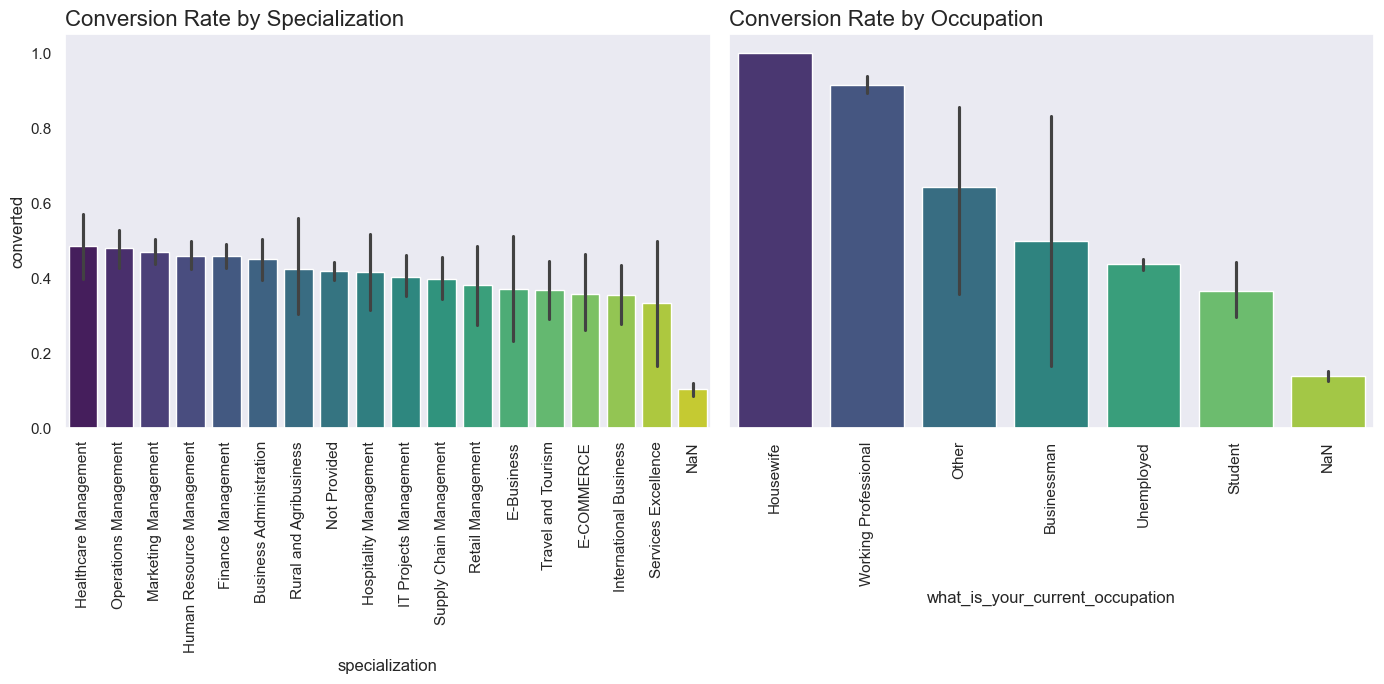

In [41]:
fig, ax  = plt.subplots(1,2, figsize=(14,7), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='specialization', y='converted',
            order=order(train_.fillna('NaN'),'specialization'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Specialization', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='what_is_your_current_occupation', y='converted',
                  order=order(train_.fillna('NaN'),'what_is_your_current_occupation'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by Occupation', loc='left', size=16)

plt.tight_layout()
plt.show()

In [42]:
train_[['what_is_your_current_occupation','specialization']].isnull().sum(1).value_counts()

0    5220
2    1141
1    1031
Name: count, dtype: int64

In [43]:
import plotly.io as pio
pio.renderers.default = "vscode" 

In [44]:
conversion_country = train_.groupby('country')['converted'].mean()
country_count = train_['country'].value_counts().sort_index()

fig = go.Figure(data=go.Choropleth(
    locations=conversion_country.index,
    locationmode='country names',
    z=conversion_country.values,
    text=country_count.values,
    colorscale='deep', 
    colorbar_title='Conversion Rate',
    hovertemplate='%{location}<br>Conversion: %{z:.2f}<br>Count: %{text}',
))

fig.update_geos(projection_type="mercator")

fig.update_layout(
    title='Conversion Rate by Country',
    geo=dict(showcoastlines=True),
    font=dict(size=16),
)

fig.show()

In [45]:
train_['country'].value_counts().sort_index()


country
Australia                  9
Bahrain                    6
Bangladesh                 2
Belgium                    2
Canada                     3
China                      2
Denmark                    1
France                     4
Germany                    4
Ghana                      2
Hong Kong                  3
India                   5201
Italy                      2
Kenya                      1
Kuwait                     3
Malaysia                   1
Netherlands                2
Nigeria                    4
Oman                       4
Philippines                1
Qatar                      9
Russia                     1
Saudi Arabia              17
Singapore                 21
South Africa               3
Sri Lanka                  1
Sweden                     2
Switzerland                1
Tanzania                   1
Uganda                     1
United Arab Emirates      49
United Kingdom            13
United States             57
Name: count, dtype: int64

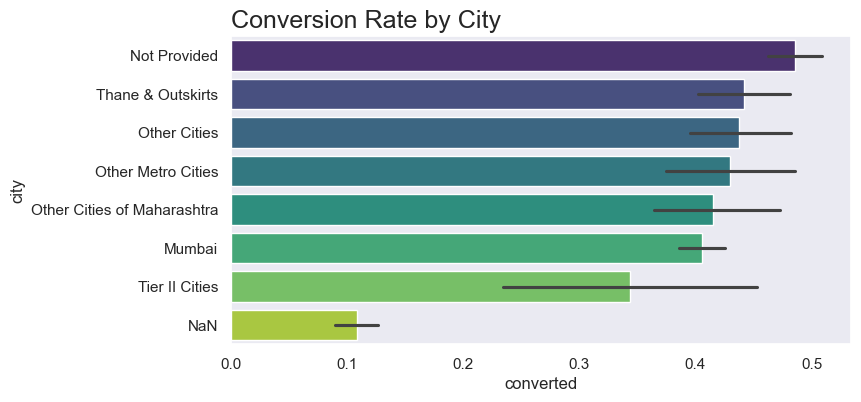

In [46]:
barplot_catcols('city',8,4)
plt.show()

In [47]:
print("Cities where country isn't India:")
train_[train_['country'] != 'India'].city.value_counts(dropna=False)

Cities where country isn't India:


city
Not Provided                   992
NaN                            693
Mumbai                         244
Other Cities                    98
Thane & Outskirts               83
Other Cities of Maharashtra     49
Other Metro Cities              27
Tier II Cities                   5
Name: count, dtype: int64

In [48]:
print('Countries where City es equal to an Indian city:')
indian_cities = ['Mumbai','Thane & Outskirts','Other Cities of Maharashtra','Tier II Cities']
train_[train_.city.isin(indian_cities)].country.value_counts(dropna=False)

Countries where City es equal to an Indian city:


country
India                   3220
NaN                      270
United States             32
United Arab Emirates      19
Singapore                 11
United Kingdom             9
Saudi Arabia               8
Australia                  6
Qatar                      5
Bahrain                    4
Germany                    3
Belgium                    2
Canada                     2
Netherlands                2
Kuwait                     1
France                     1
Sweden                     1
Malaysia                   1
Hong Kong                  1
Switzerland                1
Oman                       1
China                      1
Name: count, dtype: int64

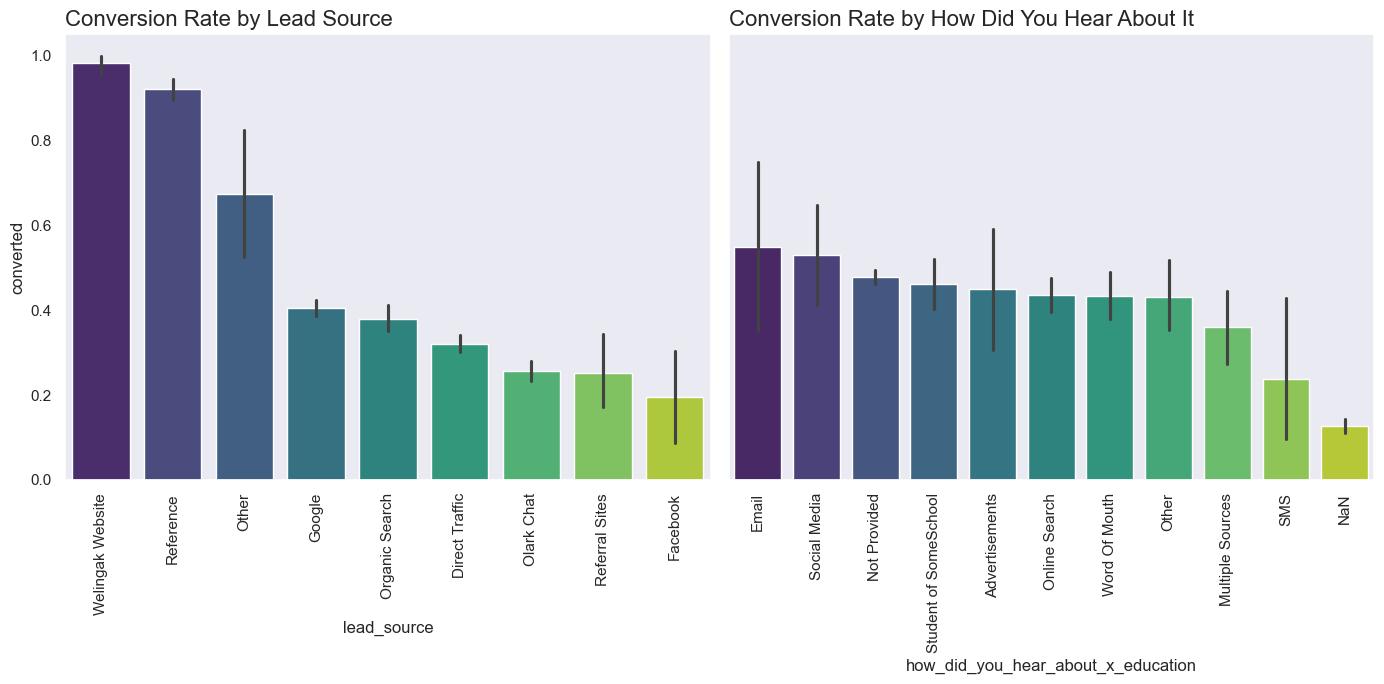

In [49]:
fig, ax  = plt.subplots(1,2, figsize=(14,7), sharey=True)

sns.barplot(data=train_.fillna('NaN'), x='lead_source', y='converted',
            order=order(train_.fillna('NaN'),'lead_source'),
            palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title(f'Conversion Rate by Lead Source', loc='left', size=16)

sns.barplot(data=train_.fillna('NaN'), x='how_did_you_hear_about_x_education', y='converted',
                  order=order(train_.fillna('NaN'),'how_did_you_hear_about_x_education'),
                  palette='viridis', seed=2)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title(f'Conversion Rate by How Did You Hear About It', loc='left', size=16)

plt.tight_layout()
plt.show()

In [50]:
train_.select_dtypes(include=['number']).nunique().sort_values()


i_agree_to_pay_the_amount_through_cheque       1
get_updates_on_dm_content                      1
update_me_on_supply_chain_content              1
receive_more_updates_about_our_courses         1
magazine                                       1
do_not_email                                   2
through_recommendations                        2
a_free_copy_of_mastering_the_interview         2
newspaper                                      2
digital_advertisement                          2
newspaper_article                              2
search                                         2
converted                                      2
do_not_call                                    2
x_education_forums                             2
asymmetrique_activity_index                    3
asymmetrique_profile_index                     3
asymmetrique_profile_score                    10
asymmetrique_activity_score                   11
amount_missing                                14
totalvisits         

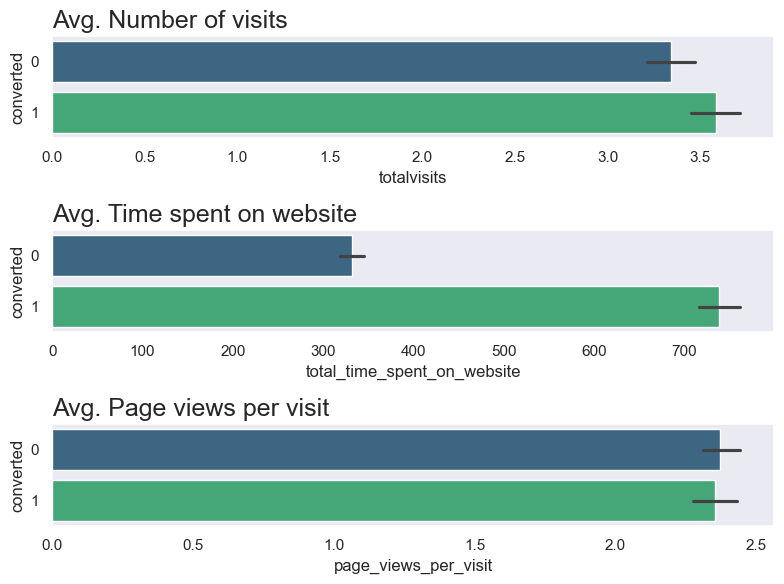

In [51]:
fig, ax  = plt.subplots(3, figsize=(8,6))
sns.barplot(data=train_, x='totalvisits', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[0])
ax[0].set_title(f'Avg. Number of visits', loc='left', size=18)

sns.barplot(data=train_, x='total_time_spent_on_website', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[1])
ax[1].set_title(f'Avg. Time spent on website', loc='left', size=18)

sns.barplot(data=train_, x='page_views_per_visit', y='converted',
            orient='h', palette='viridis',
            seed=2, ax=ax[2])
ax[2].set_title(f'Avg. Page views per visit', loc='left', size=18)

plt.tight_layout()
plt.show()

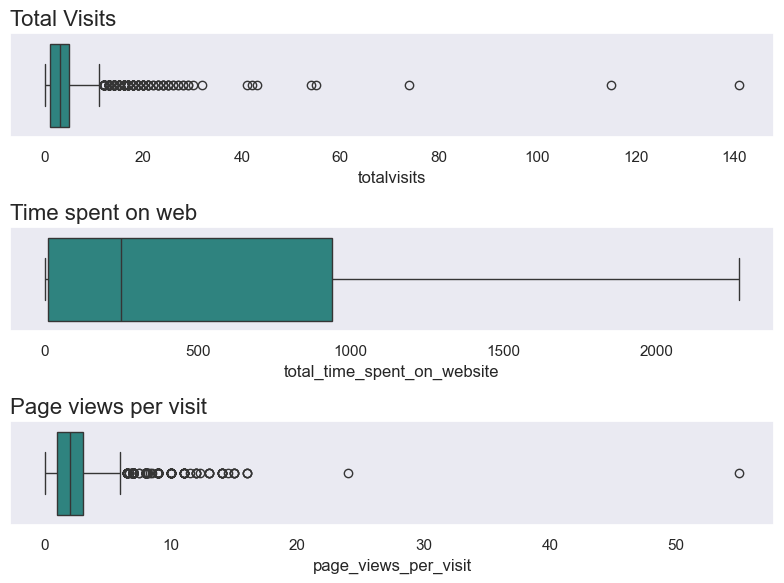

In [52]:
fig, ax = plt.subplots(3,1, figsize=(8,6))
sns.boxplot(data=train_, x='totalvisits',
              ax=ax[0], palette='viridis')
ax[0].set_title('Total Visits', loc='left', size=16)

sns.boxplot(data=train_, x='total_time_spent_on_website',
              ax=ax[1], palette='viridis')
ax[1].set_title('Time spent on web', loc='left', size=16)

sns.boxplot(data=train_, x='page_views_per_visit',
              ax=ax[2], palette='viridis')
ax[2].set_title('Page views per visit', loc='left', size=16)

plt.tight_layout()
plt.show()

In [53]:
def eda_feature_engineering(df):
  # tags column
  df['tags'] = df['tags'].str.replace('|'.join(['invalid number','wrong number given','number not provided']),'Not interest in calls')
  df['tags'] = df['tags'].str.replace('|'.join(["In confusion whether part time or DLP", "Interested in Next batch", "Shall take in the next coming month", "Still Thinking"]), "Shows certain interest")
  df['tags'] = df['tags'].str.replace("University not recognized","Not elegible")
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Not elegible' if 'holder' in x else x)
  df['tags'] = df['tags'].str.replace('|'.join(["Interested in other courses", "Interested  in full time MBA", "Not doing further education"]),"Doesn't show interest")
  df['tags'] = df['tags'].str.replace('|'.join(["Ringing","switched off"]),"Still no contact")
  df['tags'] = df['tags'].str.replace('|'.join(["Want to take admission but has financial problems", "Graduation in progress"]),"Not elegible for the moment")
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Not elegible for the moment' if 'Recognition' in x else x)
  df['tags'] = df[df['tags'].notnull()].tags.apply(lambda x: 'Other' if x not in df.tags.value_counts(dropna=False)[:12] else x)

  # country and city
  indian_cities = ['Mumbai','Thane & Outskirts','Other Cities of Maharashtra','Tier II Cities']
  df.loc[(df.country != 'India') & (df.city.isin(indian_cities)),'country'] = 'India'
  df['country'] = df.loc[df['country'].notnull(),'country'].apply(lambda x: 'Other' if x not in df.loc[df['country'] != 'Other','country'].value_counts()[:4] else x)

  # lead quality
  df['lead_quality'] = df['lead_quality'].fillna('Not Sure')

  # convert asymmetrique index columns in strings columns
  df[['asymmetrique_profile_index','asymmetrique_activity_index']] = df[['asymmetrique_profile_index','asymmetrique_activity_index']].astype(str)

  # drop columns with unique values
  drop_cols = ['magazine','receive_more_updates_about_our_courses','update_me_on_supply_chain_content',
               'get_updates_on_dm_content','i_agree_to_pay_the_amount_through_cheque']
  df = df.drop(drop_cols, axis=1)

  #add amount_missing column
  df['amount_missing'] = df.isnull().sum(1)
  return df

eda_feature_engineering = FunctionTransformer(eda_feature_engineering)

In [54]:
def cap_outliers(df):
  """Replace outliers with the 95th percentile"""
  num_cols = ['totalvisits','page_views_per_visit','total_time_spent_on_website']
  df[num_cols[0]].apply(lambda x: df[num_cols[0]].quantile(.95) if x > df[num_cols[0]].quantile(.95) else x)
  df[num_cols[1]].apply(lambda x: df[num_cols[1]].quantile(.95) if x > df[num_cols[1]].quantile(.95) else x)
  df[num_cols[2]].apply(lambda x: df[num_cols[2]].quantile(.95) if x > df[num_cols[2]].quantile(.95) else x)
  return df

cap_outliers = FunctionTransformer(cap_outliers)

In [55]:
cat_columns = ['lead_origin','lead_source','country','what_is_your_current_occupation',
                'what_matters_most_to_you_in_choosing_a_course','tags','lead_quality',
                'city','last_notable_activity']

num_cols = ['totalvisits','page_views_per_visit','total_time_spent_on_website',
            'asymmetrique_activity_score','asymmetrique_profile_score','amount_missing']

impute_knn = KNNImputer(n_neighbors=5)
impute_cons = SimpleImputer(strategy='constant', fill_value='Missing')
ohe = OneHotEncoder(handle_unknown='ignore')
sc = StandardScaler()

# Make pipelines for both type of columns treatments
pipe_cat = make_pipeline(impute_cons,ohe)
pipe_num = make_pipeline(sc,impute_knn)

impute_scale = make_column_transformer(
                                        (pipe_cat, cat_columns),
                                        (pipe_num,num_cols),
                                        remainder='drop'
                                            )

In [56]:
X_train = train.drop('Converted',axis=1)
y_train = train.loc[:,'Converted']

In [57]:
pipe = make_pipeline(
                    initial_clean,
                    initial_feature_engineering,
                    eda_feature_engineering,
                    cap_outliers,
                    impute_scale
              )
# Let's see how it looks
pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function data_cleaning at 0x11bf0c9a0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function initial_feature_engineering at 0x11bf0cf40>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function eda_feature_engineering at 0x11c3e3ba0>)),
                ('functiontransformer-4',
                 FunctionTransforme...
                                                   'what_is_your_current_occupation',
                                                   'what_matters_most_to_you_in_choosing_a_course',
                                                   'tags', 'lead_quality',
                                                   'city',
                                                   'last_notable_activity']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('knnimputer',
                                                                   KNNImputer())]),
                                                  ['totalvisits',
                                                   'page_views_per_visit',
                                                   'total_time_spent_on_website',
                                                   'asymmetrique_activity_score',
                                                   'asymmetrique_profile_score',
                                                   'amount_missing'])]))])

In [58]:
X_train_pp = pipe.fit_transform(X_train)



In [59]:
# Use stratified fold for ensure that we shuffle the dataset and conserve classes
skfold = StratifiedKFold(5, shuffle=True, random_state=12)

def display_scores(model,scores,pred):
  print(f'----------- {model} -----------')
  print('')
  print("------------------ Cross validation scores:")
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  print('')
  print("--------------- Scores in the training set:")
  print("Precision:", precision_score(y_train,pred))
  print("Recall:", recall_score(y_train,pred))
  print("F1 score:", f1_score(y_train,pred))
  print("ROC - AUC score:", roc_auc_score(y_train,pred))

In [60]:
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
lr.fit(X_train_pp,y_train)
lr_pred = lr.predict(X_train_pp)

# Precision and recall curve
lr_prec, lr_recall, lr_threshold = precision_recall_curve(y_train, lr_pred, pos_label=lr.classes_[1])
lr_prdisplay = PrecisionRecallDisplay(precision=lr_prec, recall=lr_recall)

# Display Scores
display_scores('Logistic Regression',lr_scores,lr_pred)

----------- Logistic Regression -----------

------------------ Cross validation scores:
Scores: [0.9146451  0.92003594 0.91366906 0.91785714 0.92831541]
Mean: 0.9189045324039873
Standard deviation: 0.005224837250454783

--------------- Scores in the training set:
Precision: 0.9388868679519825
Recall: 0.905931905931906
F1 score: 0.9221150410861022
ROC - AUC score: 0.9344759683742736


In [61]:
svc = SVC()
svc_scores = cross_val_score(svc, X_train_pp, y_train,
                             cv=skfold, scoring='f1')
svc.fit(X_train_pp, y_train)
svc_pred = svc.predict(X_train_pp)

# Precision and recall curve
svc_prec, svc_recall, svc_threshold = precision_recall_curve(y_train, svc_pred, pos_label=svc.classes_[1])
svc_prdisplay = PrecisionRecallDisplay(precision=svc_prec, recall=svc_recall)

# Display scores
display_scores('Support Vector Machine',svc_scores,svc_pred)

----------- Support Vector Machine -----------

------------------ Cross validation scores:
Scores: [0.91838565 0.9228039  0.9341637  0.91954023 0.93942054]
Mean: 0.9268628059368782
Standard deviation: 0.008401866887793786

--------------- Scores in the training set:
Precision: 0.9434097421203438
Recall: 0.9245349245349246
F1 score: 0.9338769721680553
ROC - AUC score: 0.9448780719967161


In [62]:
tree = DecisionTreeClassifier(random_state = 7)
tree_scores = cross_val_score(tree, X_train_pp, y_train,
                              cv=skfold, scoring='f1')
tree.fit(X_train_pp, y_train)
tree_pred = tree.predict(X_train_pp)

# Precision and recall curve
tree_prec, tree_recall, tree_threshold = precision_recall_curve(y_train, tree_pred, pos_label=tree.classes_[1])
tree_prdisplay = PrecisionRecallDisplay(precision=tree_prec, recall=tree_recall)

# Display scores
display_scores('Decission Tree',tree_scores,tree_pred)

----------- Decission Tree -----------

------------------ Cross validation scores:
Scores: [0.89630931 0.88672566 0.89565217 0.89774697 0.89631534]
Mean: 0.8945498915525263
Standard deviation: 0.003971579830443704

--------------- Scores in the training set:
Precision: 0.9912434325744308
Recall: 0.9933309933309933
F1 score: 0.9922861150070126
ROC - AUC score: 0.9939140108631633


In [63]:
rf = RandomForestClassifier(random_state=10,
                            oob_score=True)
rf_scores = cross_val_score(rf, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
rf.fit(X_train_pp, y_train)
rf_pred = rf.predict(X_train_pp)
rf_pred_proba = rf.predict_proba(X_train_pp)

# Precision and recall curve
rf_prec, rf_recall, rf_threshold = precision_recall_curve(y_train, rf_pred_proba[:,1], pos_label=rf.classes_[1])
rf_prdisplay = PrecisionRecallDisplay(precision=rf_prec, recall=rf_recall)

# Display scores
display_scores('Random Forest',rf_scores,rf_pred)
print('Oob score: ',rf.oob_score_)

----------- Random Forest -----------

------------------ Cross validation scores:
Scores: [0.92114695 0.92349235 0.93191866 0.92212389 0.94232476]
Mean: 0.9282013216982381
Standard deviation: 0.008026999867666262

--------------- Scores in the training set:
Precision: 0.9908995449772489
Recall: 0.9936819936819937
F1 score: 0.9922888187872415
ROC - AUC score: 0.9939794516065702
Oob score:  0.9433170995670995


In [64]:
xg = GradientBoostingClassifier(random_state=11)
xg_scores = cross_val_score(xg, X_train_pp, y_train,
                            cv=skfold, scoring='f1')
xg.fit(X_train_pp, y_train)
xg_pred = xg.predict(X_train_pp)

# Precision and recall curve
xg_prec, xg_recall, xg_threshold = precision_recall_curve(y_train, xg_pred, pos_label=xg.classes_[1])
xg_prdisplay = PrecisionRecallDisplay(precision=xg_prec, recall=xg_recall)

# Display scores
display_scores('Gradient Boosting',xg_scores,xg_pred)

----------- Gradient Boosting -----------

------------------ Cross validation scores:
Scores: [0.91960253 0.92391304 0.92585895 0.91921005 0.9375    ]
Mean: 0.9252169155744518
Standard deviation: 0.006642140850639732

--------------- Scores in the training set:
Precision: 0.9579180509413068
Recall: 0.9108459108459108
F1 score: 0.9337891327815762
ROC - AUC score: 0.9428761801643157


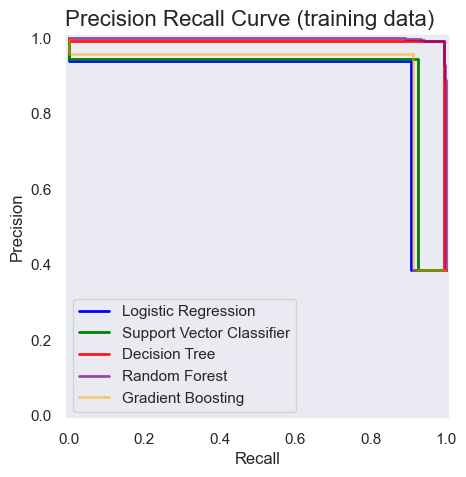

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
lr_prdisplay.plot(ax=ax, label='Logistic Regression', color='blue', linewidth=2)
svc_prdisplay.plot(ax=ax, label='Support Vector Classifier', color='green', linewidth=2)
tree_prdisplay.plot(ax=ax, label='Decision Tree', color='red', linewidth=2, alpha=.9)
rf_prdisplay.plot(ax=ax, label='Random Forest', color='purple', linewidth=2, alpha=.7)
xg_prdisplay.plot(ax=ax, label='Gradient Boosting', color='orange', linewidth=2, alpha=.5)
plt.title('Precision Recall Curve (training data)', size=16, loc='left')
plt.show()

In [66]:
lr_params = [
              {'C': uniform(loc=0, scale=4),
              'penalty': ['l1','l2'],
              'solver': ['liblinear','saga']}
              ]

lr_randomcv = RandomizedSearchCV(lr, lr_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=100)

lr_randomcv.fit(X_train_pp, y_train)

print("---------------- Logistic Regression ---------------")
print("Best Parameters: ", lr_randomcv.best_params_)
print("Best Score: ", lr_randomcv.best_score_)

---------------- Logistic Regression ---------------
Best Parameters:  {'C': np.float64(2.601588727725869), 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  0.9211513665588912


In [67]:
rf_params = [{
              'n_estimators': np.arange(50,500,50),
              'criterion': ['gini','entropy','logloss'],
              'max_depth': np.arange(2,14,2),
              'max_features': ['sqrt','log2',None, 0.5],
              }]

rf_randomcv = RandomizedSearchCV(rf, rf_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=100)

rf_randomcv.fit(X_train_pp, y_train)

print("----------------- Random Forest ----------------")
print("Best Parameters: ", rf_randomcv.best_params_)
print("Best Score: ", rf_randomcv.best_score_)

----------------- Random Forest ----------------
Best Parameters:  {'n_estimators': np.int64(250), 'max_features': 0.5, 'max_depth': np.int64(12), 'criterion': 'gini'}
Best Score:  0.9305705475334353


In [68]:
xg_params = [{
              'n_estimators': np.arange(50,500,50),
              'loss': ['exponential','log_loss'],
              'max_depth': np.arange(2,14,2),
              'criterion': ['friedman_mse', 'squared_error'],
              'learning_rate': uniform(loc=0,scale=.5),
              'max_features': ['sqrt', 'log2', None, 0.5]
              }]

xg_randomcv = RandomizedSearchCV(xg, xg_params, cv=skfold,
                                 scoring='f1',
                                 return_train_score = True,
                                 random_state = 10,
                                 n_iter=50)

xg_randomcv.fit(X_train_pp, y_train)

print("--------------- Gradient Boosting --------------")
print("Best Parameters: ", xg_randomcv.best_params_)
print("Best Score: ", xg_randomcv.best_score_)

--------------- Gradient Boosting --------------
Best Parameters:  {'criterion': 'friedman_mse', 'learning_rate': np.float64(0.2534893146320237), 'loss': 'exponential', 'max_depth': np.int64(6), 'max_features': 'log2', 'n_estimators': np.int64(50)}
Best Score:  0.9301266053720096


In [69]:
X_test = test.drop('Converted',axis=1)
y_test = test.loc[:,'Converted']

# Let's take a look of the first row
X_test.to_numpy()[:1]


array([['b4d86fa1-53d9-4a27-8d0c-f6603a562184', 634844, 'API', 'Google',
        'No', 'No', 2.0, 1551, 1.0, 'SMS Sent', 'India', nan, nan, nan,
        nan, 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', nan, nan,
        'No', 'No', nan, nan, '02.Medium', '02.Medium', 15.0, 15.0, 'No',
        'No', 'SMS Sent']], dtype=object)

In [70]:
# apply all the preprocessing steps to the test dataset
X_test_pp = pipe.transform(X_test)
X_test_pp.toarray()[:1]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0. 

In [71]:
rf_rcv_pred = rf_randomcv.predict(X_test_pp)
print("Precision:", precision_score(y_test,rf_rcv_pred))
print("Recall:", recall_score(y_test,rf_rcv_pred))
print("F1 score:", f1_score(y_test,rf_rcv_pred))
print("ROC - AUC score:", roc_auc_score(y_test,rf_rcv_pred))

Precision: 0.9526627218934911
Recall: 0.9044943820224719
F1 score: 0.9279538904899135
ROC - AUC score: 0.9381626839689825


In [72]:
rf_pred_test = rf.predict(X_test_pp)
print("Precision:", precision_score(y_test,rf_pred_test))
print("Recall:", recall_score(y_test,rf_pred_test))
print("F1 score:", f1_score(y_test,rf_pred_test))
print("ROC - AUC score:", roc_auc_score(y_test,rf_pred_test))

Precision: 0.9373177842565598
Recall: 0.9030898876404494
F1 score: 0.9198855507868383
ROC - AUC score: 0.9326188874821965


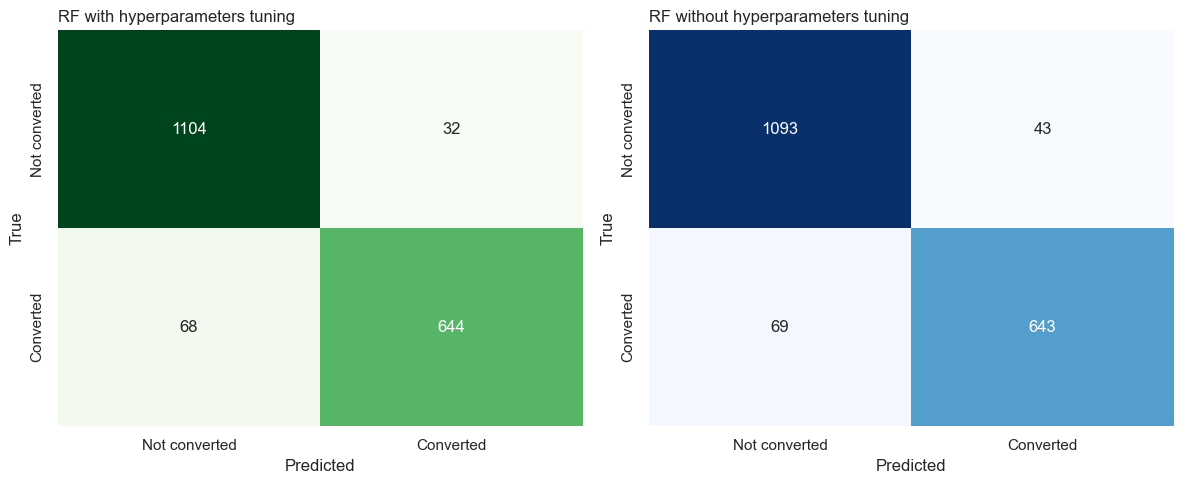

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest tunned
cm1 = confusion_matrix(y_test, rf_rcv_pred)
sns.heatmap(cm1, annot=True, fmt = 'd', cmap='Greens', ax = ax[0], cbar=False)
ax[0].xaxis.set_ticklabels(['Not converted', 'Converted'])
ax[0].yaxis.set_ticklabels(['Not converted', 'Converted'])
ax[0].set_title('RF with hyperparameters tuning', loc='left')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Random Forest without tuning
cm2 = confusion_matrix(y_test, rf_pred_test)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False)
ax[1].xaxis.set_ticklabels(['Not converted', 'Converted'])
ax[1].yaxis.set_ticklabels(['Not converted', 'Converted'])
ax[1].set_title('RF without hyperparameters tuning', loc='left')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [74]:
lead_scoring = rf_randomcv.predict_proba(X_test_pp)[:,1]
lead_prediction = rf_rcv_pred
results = np.round(np.c_[lead_prediction,lead_scoring],2)

# Let's take a look of the first 10 rows
results[:10]

array([[1.  , 0.95],
       [0.  , 0.18],
       [0.  , 0.01],
       [0.  , 0.01],
       [1.  , 0.94],
       [1.  , 1.  ],
       [1.  , 1.  ],
       [1.  , 0.71],
       [0.  , 0.01],
       [0.  , 0.17]])